# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Author:Himanshu Singh Sikarwar
# Date:19-02-2023
import torch
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn
from torch import tensor
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import argparse
from collections import OrderedDict
import PIL
from PIL import Image
import time



## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define the data transforms for each dataset split
data_trans_forms = { 
    'training': transforms.Compose([
        transforms.RandomResizedCrop(size=224), # Randomly crop the image to size 224
        transforms.RandomRotation(30), # Rotate the image by a random angle between -30 and 30 degrees
        transforms.ToTensor(), # Convert the image to a PyTorch tensor
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]) # Normalize the image with mean and standard deviation values
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=256), # Resize the image to 256x256
        transforms.CenterCrop(size=224), # Center crop the image to size 224
        transforms.ToTensor(), # Convert the image to a PyTorch tensor
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]) # Normalize the image with mean and standard deviation values
    ]),
    'testing': transforms.Compose([
        transforms.Resize(size=256), # Resize the image to 256x256
        transforms.CenterCrop(size=224), # Center crop the image to size 224
        transforms.ToTensor(), # Convert the image to a PyTorch tensor
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]) # Normalize the image with mean and standard deviation values
    ])
}

# Load the datasets with ImageFolder
image_data_sets = {
    'training': datasets.ImageFolder(train_dir, transform=data_trans_forms['training']),
    'validation': datasets.ImageFolder(valid_dir, transform=data_trans_forms['validation']),
    'testing': datasets.ImageFolder(test_dir, transform=data_trans_forms['testing'])
}

# Using the image datasets and the trainforms, define the dataloaders
# Batch size is set to 64 and shuffle is set to True for the training, validation and test loaders
dataloaders = train_loader = torch.utils.data.DataLoader(image_data_sets['training'], batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(image_data_sets['validation'], batch_size =64,shuffle = True)
test_loader = torch.utils.data.DataLoader(image_data_sets['testing'], batch_size = 64, shuffle = True)

# Get the sizes of the training, validation and test loaders
train_Loader_size = len(train_loader)
valid_Loader_size = len(validation_loader)
test_loader_size = len(test_loader)
train_Loader_size, valid_Loader_size, test_loader_size

(103, 13, 13)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(len(cat_to_name))

102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
# TODO: Build and train your network
# loads a pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezes the parameters of the model
for param in model.parameters():
    param.requires_grad = False

# defines the custom classifier with 3 hidden layers and an output layer
classifier = nn.Sequential(OrderedDict([
    ('input', nn.Linear(25088, 6272)), # input layer
    ('relu1', nn.ReLU()), # first ReLU activation function
    ('dropout01', nn.Dropout(0.05)), # first dropout layer
    ('hiddenlayer1', nn.Linear(6272,1045)), # first hidden layer
    ('relu2',nn.ReLU()), # second ReLU activation function
    ('hiddenlayer2', nn.Linear(1045,522)), # second hidden layer
    ('relu3',nn.ReLU()), # third ReLU activation function
    ('hiddenlayer3', nn.Linear(522,102)), # third hidden layer
    ('output', nn.LogSoftmax(dim=1)) # output layer with LogSoftmax activation function
]))

# replaces the pre-trained classifier with the custom one defined above
model.classifier = classifier


In [6]:
# Checks if GPU is available, otherwise uses CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Moves model to the specified device (GPU or CPU)
model.to(device)

# Prints device in use
print(f'The device in use is {device}.\n')

# Number of times the model will loop through the entire training dataset
epochs = 10

# Defines the optimizer to be used
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) 

# Defines the loss function to be used
criterion = nn.NLLLoss() 

# The frequency at which training progress is printed out
print_after = 50

# Running totals for loss and accuracy
runned_loss = running_accuracy = 0

# Lists for storing validation and training loss
losses_after_validation, training_losses = [], []

# Loops through the entire dataset 'epochs' number of times
for e in range(epochs):
    # Counter for the number of batches
    batches = 0 

    # Switches to training mode
    model.train()

    # Loops through the training dataset in batches
    for images, labels in train_loader:
        # Start time for measuring batch training time
        starting_time = time.time() 

        # Increments the batch counter
        batches += 1

        # Sends the images and labels to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        log_ps = model.forward(images)

        # Calculates the loss
        losss = criterion(log_ps, labels)

        # Backward pass through the model
        losss.backward()

        # Optimizes the model
        optimizer.step()

        # Calculates the accuracy
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1,dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        accuracy = matches.mean()

        # Resets the optimizer gradients and updates the metrics
        optimizer.zero_grad()
        runned_loss += losss.item()
        running_accuracy += accuracy.item()

        # Runs the model on the validation set every 'print_after' loops
        if batches % print_after == 0:
            # End time for measuring batch training time
            end_time = time.time()
            training_time = end_time - starting_time

            # Resets the validation loss and accuracy
            val_loss = 0
            val_accuracy = 0

            # Switches to evaluation mode and disables gradient calculation
            model.eval()
            with torch.no_grad():
                # Loops through the validation dataset
                for images, labels in validation_loader:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model.forward(images)
                    losss = criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
                    accuracy = matches.mean()

                    # Tracks the validation metrics
                    val_loss += losss.item()
                    val_accuracy += accuracy.item()
                
            # Calculates the training and validation loss and accuracy
            end_time = time.time()
            validating_timing = end_time - starting_time
            losses_after_validation.append(runned_loss / print_after)
            training_losses.append(val_loss / len(validation_loader))
                
            # Prints out the metrics
            print(f'Epoch {e+1}/{epochs} | Batch {batches}')
            print(f'RunningTraining Loss: {runned_loss/print_after:.3f}')
            print(f'Running Training Accuracy: {running_accuracy/print_after*100:.2f}%')
            print(f'Validation Loss: {val_loss/len(validation_loader):.3f}')
            print(f'Validation Accuracy: {val_accuracy/len(validation_loader)*100:.2f}%')

            # resets the metrics and turns on training mode
            runned_loss = running_accuracy = 0
            model.train()

The device in use is cuda:0.

Epoch 1/10 | Batch 50
RunningTraining Loss: 4.167
Running Training Accuracy: 9.12%
Validation Loss: 3.125
Validation Accuracy: 26.29%
Epoch 1/10 | Batch 100
RunningTraining Loss: 2.637
Running Training Accuracy: 33.38%
Validation Loss: 1.881
Validation Accuracy: 49.02%
Epoch 2/10 | Batch 50
RunningTraining Loss: 2.099
Running Training Accuracy: 49.79%
Validation Loss: 1.590
Validation Accuracy: 57.93%
Epoch 2/10 | Batch 100
RunningTraining Loss: 1.692
Running Training Accuracy: 54.12%
Validation Loss: 1.298
Validation Accuracy: 64.77%
Epoch 3/10 | Batch 50
RunningTraining Loss: 1.558
Running Training Accuracy: 63.41%
Validation Loss: 1.132
Validation Accuracy: 68.62%
Epoch 3/10 | Batch 100
RunningTraining Loss: 1.406
Running Training Accuracy: 60.72%
Validation Loss: 1.075
Validation Accuracy: 71.92%
Epoch 4/10 | Batch 50
RunningTraining Loss: 1.346
Running Training Accuracy: 68.79%
Validation Loss: 1.056
Validation Accuracy: 71.72%
Epoch 4/10 | Batch 100


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [7]:
# TODO: Do validation on the test set
# import time
# import torch

# Define variables
testing_accu = 0
starting_time = time.time()

# Print message to indicate start of validation
print('Validation started.')

# Iterate through test set and perform validation
for images, labels in test_loader:
    model.eval()
    images, labels = images.to(device), labels.to(device)
    log_ps = model.forward(images)
    ps = torch.exp(log_ps)
    top_ps, top_class = ps.topk(1, dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    testing_accu += accuracy

# Record ending time and print message to indicate end of validation
ending_time = time.time()
print('Validation ended.')

# Calculate validation time and print result
validation_time = ending_time - starting_time
print('Validation time: {:.0f}m {:.0f}s'.format(validation_time / 60, validation_time % 60))

# Calculate and print test accuracy
print(f'Test Accuracy: {testing_accu / len(test_loader) * 100:.2f}%')


Validation started.
Validation ended.
Validation time: 0m 18s
Test Accuracy: 81.18%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [8]:
# TODO: Save the checkpoint 
###########################################################
# Author: Himanshu Singh Sikarwar
# Date: 20-Feb-2023
# Description: Saves a PyTorch model checkpoint
###########################################################

# import torch

# Set the values for the checkpoint
EPOCH = 9
PATH = "_checkpoint.pth"
DROPOUT = 0.05

# Get the class to index mapping from the image data set
model.class_to_idx = image_data_sets['training'].class_to_idx

# Save the checkpoint
torch.save({
            'hidden_layer1': 6272,
            'hidden_layer2': 1045,
            'hidden_layer3': 522,
            'output_layer': 102,
            'structure': 'vgg16',
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'model_class_2_index': model.class_to_idx,
            }, PATH)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# author:himanshu singh sikarwar
# date:22-feb-2023
# import torch
# import torchvision.models as models


def load_the_checkpoint(path='checkpoint.pth', device='cpu'):
    try:
        checkpoint = torch.load(path, map_location=device)
    except (FileNotFoundError, RuntimeError) as e:
        print(f"Failed to load checkpoint from file '{path}': {e}")
        return None

    model = models.vgg16(pretrained=True)

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Load model state dict from checkpoint
    model.class_to_idx = checkpoint['model_class_2_index']
    model.load_state_dict(checkpoint['model_state_dict'])

    # Move the model to the specified device
    model.to(device)

    return model


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
# import numpy as np
# from PIL import Image
# import torch
# from torchvision import transforms

# Define the location of the image to preprocess
# image_path = './flowers/test/70/image_05331.jpg'

def process_image(image):
    """Preprocesses an image and returns it as a numpy array.

    Args:
        image_path (str): The path of the image to preprocess.

    Returns:
        np.ndarray: The preprocessed image as a numpy array.
    """
    # Open the image and convert to RGB
    a_image = Image.open(image).convert('RGB')
    
    # Resize the image while keeping its aspect ratio
    a_image.thumbnail(size=(256, 256))
    
    # Get the dimensions of the image
    width, height = a_image.size
    
    # Crop the center of the image to a 224x224 square
    crop_size = 224
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2
    a_image = a_image.crop((left, top, right, bottom))
    
    # Convert the image to a PyTorch tensor and normalize it
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    tensor = normalize(to_tensor(a_image))
    
    # Convert the tensor to a numpy array
    np_array = tensor.numpy()
# np_processed_image = tensor.numpy()
    
    
    return np_array



To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

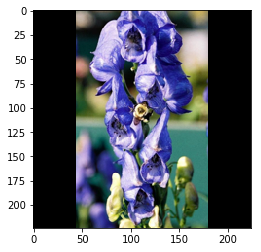

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/9/image_06413.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [15]:

def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

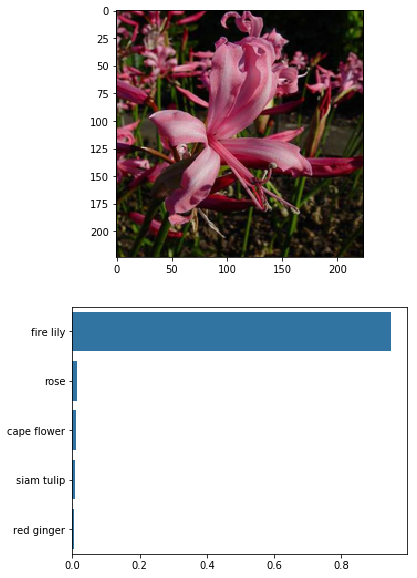

In [16]:
# TODO: Display an image along with the top 5 classes
# Define image path
image_path = "flowers/test/37/image_03734.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()



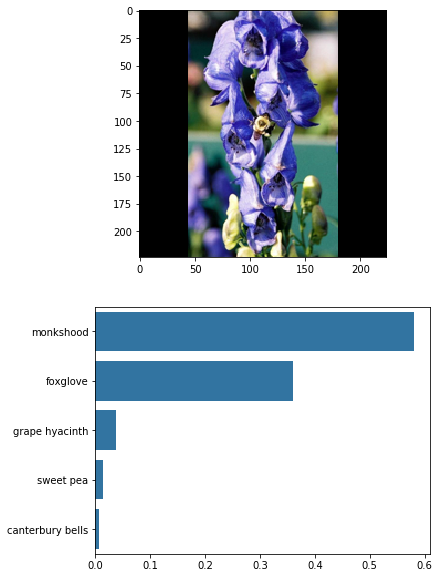

In [17]:
image_path = "flowers/test/9/image_06413.jpg"
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]
img = process_image(image_path)
imshow(img, ax, title = title_);
probs, labs, flowers = predict(image_path, model) 
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()


<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [14]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace

In [18]:
#done
#date:24-feb-2023
# author:himanshusingh sikarwar